# Previsão de Séries Temporais com Programação Genética
Este exercício tem o objetivo de utilizar Programaçã Genética para gerar um modelo de previsão de séries temporais. Os dados utilizados são referente ao número mensal de passageirosde linhas aéreas internacionais (em milhares/mês), desde janeir/1949 a dezembro/1960, conforme figura abaixo.
![grafico](serie-grafico.png)

O primeiro passo foi criar o dataset com os dados da planilha fornecida. Separou-se em dois datasets: treinamento e teste.  
Como **janela de periodicidade**, observou-se que a cada 12 passo o padrão se repetia, o que corresponde a um ano **(12 meses)**. Sendo assim utilizou-se esse valor para gerar uma matriz que contivesse 12 entradas e uma saída.

In [1]:
import numpy as np
from numpy import genfromtxt

#lendo do arquivo
data = genfromtxt('serie.txt')
data = np.array([[data[index+pos] for pos in range(13)] for index in range(data.size - 12)])

#separando os conjuntos
DATA_TRAIN_SIZE = data[:,1].size - 12
data_train = data[:DATA_TRAIN_SIZE,:]
data_test = data[DATA_TRAIN_SIZE:,:]
data_train_in = data[:DATA_TRAIN_SIZE,:12]
data_train_out = data[:DATA_TRAIN_SIZE,12]
data_test_in = data[DATA_TRAIN_SIZE:,:12]
data_test_out = data[DATA_TRAIN_SIZE:,12]

Para a implementação do algoritmo de Programação Genética, utilizou-se o **DEAP** *(Distributed Evolutionary Algorithms in Python)*. Abaixo realiza-se o import dos modulos que serão utilizados.

In [2]:
import operator
import math
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Define-se agora a estrutura da árvore que será gerada nas evoluções da PG. Esta árvore terá 12 entradas que correspnde a janela definida de 12 meses. Também serão definidas as funções e os terminais utilizados.

In [3]:
#definicao da estrutura de um conjunto que terá 12 entradas
pset = gp.PrimitiveSet("MAIN", 12)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

In [4]:
pset.addEphemeralConstant("rand101", lambda: random.randint(-180,180)) #terminal que gera um numero aleatorio entre [-1,1]

Os argumentos(entradas) serão renomeados para facilitar o entendimento da arvore gerada posteriormente. Cada argumento representa um mês do ano.

In [5]:
pset.renameArguments(ARG0='x1')
pset.renameArguments(ARG1='x2')
pset.renameArguments(ARG2='x3')
pset.renameArguments(ARG3='x4')
pset.renameArguments(ARG4='x5')
pset.renameArguments(ARG5='x6')
pset.renameArguments(ARG6='x7')
pset.renameArguments(ARG7='x8')
pset.renameArguments(ARG8='x9')
pset.renameArguments(ARG9='x10')
pset.renameArguments(ARG10='x11')
pset.renameArguments(ARG11='x12')

Na sequencia, será definido o alicerce da PG:  
- característica do problema(minimização ou maximização)  
- método de geração da população(grow, full, half and half)  
- função de fitness  
- função de crossover  
- função de mutação  
- função de seleção  
- definição da profundidade máxima da árvore

In [6]:
#característica do problema
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#tipo do indivíduo = árvore
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
#método de geração da população
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#compila a arvore gerada em uma função
toolbox.register("compile", gp.compile, pset=pset)

#função de fitness que compara a arvore gerada com os dados de treinamento
def fitness(individual):
    # Tranforma a expressao da arvore em um função invocável
    func = toolbox.compile(individual)
    
    # calcula o erro quadrado médio entre a expressao e o valor real 'y'
    sqerrors = ((func(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12)-y)**2 for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y in data_train)
    
    return math.fsum(sqerrors) / len(data_train),

#define para o framework qual será a função de fitness utilizada
toolbox.register("evaluate", fitness)
#define o operador de seleção como torneio de tamanho 3
toolbox.register("select", tools.selTournament, tournsize=3)
#define função de cruzamento como corte em um ponto
toolbox.register("mate", gp.cxOnePoint)
#cria função de mutação utilizando o método de geração full
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
#define a função de mutação para o framework
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#quando houver cruzamento o tamanho da arvore nao pode passar de 50
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
#quando houver muatção o tamanho da arvore nao pode passar de 50
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

Com toda a estrutura definida agora é possível criar a função que de fato irá rodar  algoritmo.

In [7]:
def algorithm():
    random.seed(318)
    #CXPB  - Probabilidade de crossover
    #MUTPB - Probabilidade de mutação
    #NGEN  - Numero de gerações
    CXPB, MUTPB, NGEN = 0.5, 0.1, 50

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # Realiza a chamada do algortimo definido no capitulo 7 do KOZA.
    # Passa como parâmetros:
    #     - população
    #     - toolbox que é o objeto que representa o framework DEAP
    #     - parametros evolucionais (probabilidades de crossover e mutação e gerações)
    #     - objeto com os placeholders de estatística
    #     - halloffame - individuo(s) selecionado(s)
    #     - verbos que representa se será impresso nas saida a evolução do algoritmo
    pop, log = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=mstats,
                                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

In [8]:
pop, log, hof = algorithm()

   	      	                      fitness                      	              size             
   	      	---------------------------------------------------	-------------------------------
gen	nevals	avg        	max        	min    	std        	avg    	max	min	std    
0  	300   	1.65318e+13	4.95914e+15	1188.26	2.85838e+14	3.20667	7  	2  	1.34063
1  	156   	2.45135e+11	7.35251e+13	1055.86	4.23789e+12	3.21333	9  	1  	1.3321 
2  	158   	2.58636e+07	7.74045e+09	578.25 	4.46146e+08	3.6    	10 	1  	1.60416
3  	176   	3.15111e+12	9.45297e+14	578.25 	5.44857e+13	3.76   	10 	1  	1.78393
4  	160   	28649.4    	708815     	578.25 	83106      	3.52667	10 	1  	1.93286
5  	165   	1.99292e+06	3.79224e+08	578.25 	2.50021e+07	3.16   	10 	1  	1.95305
6  	161   	4.27594e+06	1.27894e+09	578.25 	7.37159e+07	2.8    	10 	1  	1.86905
7  	140   	1.05843e+08	8.15082e+09	578.25 	8.98295e+08	2.78   	12 	1  	1.8106 
8  	168   	15535.6    	312142     	578.25 	36882.4    	3.06667	10 	1  	1.57551
9  	174   	7.01682e+

## Resultados

### 1. Análise de parâmetros e funções

- Cenário simplista - apenas operação se soma e subtração e terminal randomico entre [-1,1]: Obteve um erro de aproximadamente 9% e uma função bem simples  
- Cenário complexo - Com mais operações: Obteve um erro de aproximadamente 5% e um função simples também.  

A adição e funções mais complexas como exponencial implica em incluir restrições para não dar erro ao calcular o fitness ou gerar um filho.

### 2. Melhor expressão-S obtida

In [9]:
str(hof[0])

'add(x1, 27)'

### 3. Equação correspondente(simplificada)

[escrever]

### 4. Planilha com os dados obtidos

In [10]:
import pandas as pd
cols = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','REAL','PG','ERRO']
function = gp.compile(hof[0],pset)
table = []
for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y in data_train:
    pg = function(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12)
    table.append([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y,pg,abs(100-pg*100/y)])
table = np.array(table)
df = pd.DataFrame(table,columns = cols)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,REAL,PG,ERRO
0,112.0,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,139.0,20.869565
1,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,145.0,15.079365
2,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,159.0,12.765957
3,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,156.0,15.555556
4,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,148.0,18.400000
5,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,162.0,8.724832
6,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,175.0,2.941176
7,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,170.0,175.0,2.941176
8,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,170.0,158.0,163.0,3.164557
9,119.0,104.0,118.0,115.0,126.0,141.0,135.0,125.0,149.0,170.0,170.0,158.0,133.0,146.0,9.774436


### 5. Gráfico com os dados reais e os gerados pela função obtida por PG

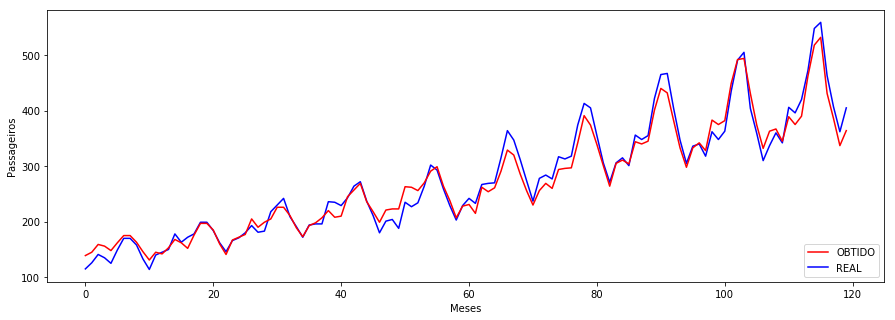

In [14]:
import matplotlib.pyplot as plt

meses = np.arange(120)

fig, ax1 = plt.subplots()
ax1.set_xlabel("Meses")
ax1.set_ylabel("Passageiros")

line1 = ax1.plot(meses, table[:,12], "b-", label="REAL")
line2 = ax1.plot(meses, table[:,13], "r-", label="OBTIDO")

lns = line2 + line1
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=4)

fig.set_size_inches(15, 5, forward=True)

plt.show()

In [12]:
print('Erro médio: {}%'.format(sum(table[:,14])/len(table)))

Erro médio: 5.2772354481839745%


### 6. Considerações finais

[considerações sobre o uso de PG para previsão de séries temporais]